In [2]:
import sys
sys.path.append('../')
sys.path.append('../support/')
sys.path.append('../lung_segmentation/')

from preprocessing import *
from ct_reader import *
import pandas as pd
from os.path import join, basename, isfile
from scipy.ndimage.interpolation import zoom
from glob import glob
from multiprocessing import Pool
from scipy.ndimage import morphology
from scipy.ndimage import label
from skimage import measure
from tqdm import tqdm
from multiprocessing import Pool
import pickle
%pylab inline
from paths import * 
from skimage.transform import resize
import warnings
import seaborn as sns
sns.set_style('ticks')

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
def read_ct(path, ret_xy_spacing=False, ret_original_format=True):
    patient = read_ct_scan(path)
    image = get_pixels_hu(patient)
#     image[image == image[0,0,0]] = 0
    
    if ret_original_format:
        return image, patient
    
    if ret_xy_spacing:
        return image, patient.GetSpacing()[0]
    
    return image

In [6]:
def region_growing(img, seed, maxthr, structure=None):
    """code was tekan from:
    https://github.com/loli/medpy/wiki/Basic-image-manipulation
    """
    thrimg = img < maxthr
    lmap, _ = label(thrimg, structure=structure)
    lids = unique(lmap[seed])
    region = zeros(img.shape, numpy.bool)
    for lid in lids:
        region |= lmap == lid
    return region

In [7]:
def segment_nodules(patch, mask, is_nodule=True, magic_const=50):
    prepared = (patch - patch.min()) / (patch.max() - patch.min())

    kmeans = KMeans(n_clusters=2)

    if IS_NODULE:
        coords = where(mask == 2)
    else:
        coords = where(mask >= 0)
    
    

    data = prepared[coords]
    
    if data.shape[0] <= 2:
        return mask
    
    data = kmeans.fit_predict(expand_dims(data, 1))

    kmean = zeros(mask.shape)
    kmean[coords] = data + magic_const
    labels, num = label(kmean, return_num=True, background=0)

    nodule_a = argmax([sum(labels == i) for i in range(1, num + 1)]) + 1
    init = kmeans.predict(expand_dims(prepared[labels == nodule_a], 1)).min()
    nodule_b = list()
    for i in range(1, num + 1):
        if i != nodule_a:
            if kmeans.predict(expand_dims(prepared[where(labels == i)], 1)).min() != init:
                nodule_b.append((sum(labels == i), i))

    nodule_b = max(nodule_b)[1]

    A = prepared[labels == nodule_a]
    B = prepared[labels == nodule_b]

    if mean(A.reshape(-1)) > mean(B.reshape(-1)):
        labels = labels == nodule_a
    else:
        labels = labels == nodule_b

    return labels

In [8]:
BORDER = 32
SPACING = array([.9, .7, .7])
CPU = 24

In [9]:
candidates = pd.read_csv(join(PATH['LUNA_CSV'], 'candidates.csv'))
annotations = pd.read_csv(join(PATH['LUNA_CSV'], 'annotations.csv'))
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


In [6]:
test = load(join(PATH['WEIGHTS'], 'test.npy'))
valid = load(join(PATH['WEIGHTS'], 'valid.npy'))
train = load(join(PATH['WEIGHTS'], 'train.npy'))

In [10]:
def get_remind_files():
    file_list = set(path for path in candidates.seriesuid)
#     file_list = file_list.difference([basename(path).split('.npy')[0][:64] 
#                             for path in glob(join(PATH['LUNA_VESSELS'], 'subset*', '*.npy'))]

#                             + [basename(path).split('.npy')[0][:64] 
#                                  for path in glob(join(PATH['LUNA_NODULES'], 'subset*', '*.npy'))])

    file_list = [[(join(PATH['LUNA_DATA'], 'subset' + str(i), base_name + '.mhd'), i)
                  for i in range(10) 
                  if isfile(join(PATH['LUNA_DATA'], 'subset' + str(i), base_name + '.mhd'))] 
                 for base_name in file_list]

    folders = [path[0][1] for path in file_list]
    file_list = [path[0][0] for path in file_list]
    return file_list, folders

In [12]:
def overlap(lung, mask):
#     iso = binary_dilation(imresize(isolated[163], (512, 512)))
    labeled, num = label(mask)
    coords = list()
    for colour in range(1, labeled.max() + 1):
        coords.append(where(labeled == colour))
    coords = array([[int(coord[0].mean() / SPACING[0])
                     for coord in coords], 
                    [int(coord[1].mean() / SPACING[1])
                     for coord in coords],
                    [int(coord[2].mean() / SPACING[2])
                     for coord in coords]])

    lung = pad(lung, 
               ((BORDER, BORDER), 
                (BORDER, BORDER), 
                (BORDER, BORDER)), 
               mode='edge')
    patches = list()
    for coord in coords.T:
        patch = lung[coord[0]: coord[0] + 2 * BORDER,
                     coord[1]: coord[1] + 2 * BORDER,
                     coord[2]: coord[2] + 2 * BORDER]
        patches.append(patch)

    return patches, coords

In [13]:
def operate(path, upsides):
    lung, ct_lung = read_ct(path, ret_original_format=True)
    
    lung, spacing = resample(lung, ct_lung, SPACING)
    
    name = basename(path)
    mask = load(join(PATH['DATA_ENHANCED'], 
                     name + '.npy'))
    
#     mask, spacing = resample(mask, (1, 1, 1), SPACING)
    
    incorrects = list()
    if name in upsides:
        lung = flipud(lung)
        mask = flipud(mask)
        incorrects.append(-1)
        
    batch, coords = overlap(lung, mask)
    
    for patch, coord in zip(batch, coords.T):
        if patch.shape != (2 * BORDER, 
                           2 * BORDER, 
                           2 * BORDER):
            incorrects.append((path, coord))
            continue
        
        save(join(PATH['ENHANCED_CROPPED'], 
                  name + '_'.join([str(coord[0]), 
                                   str(coord[1]), 
                                   str(coord[2])])), 
             patch.astype(int16))
    return incorrects

In [14]:
def get_remind_files():
    file_list = set(glob(join(PATH['DATA'], '*')))
    file_list = file_list.difference(set([join(PATH['DATA'], basename(path).split('.npy')[0][:32]) 
                            for path in glob(join(PATH['ENHANCED_CROPPED'], '*.npy'))]))

    return sorted(list(file_list))

In [ ]:
def overlap(lung, name, candidates, origin, spacing=SPACING):
    nodules = candidates[candidates.seriesuid == name]
    lung = pad(lung, 
               ((BORDER, BORDER), 
                (BORDER, BORDER), 
                (BORDER, BORDER)), 
               mode='edge')
    patches = list()
    cancer = list()
    rows = list()
    for i, row in nodules.iterrows():
        X = ceil((row.coordX - origin[0]) / spacing[1] + BORDER)
        Y = ceil((row.coordY - origin[1]) / spacing[2] + BORDER)
        Z = ceil((row.coordZ - origin[2]) / spacing[0] + BORDER)
        patches.append(lung[Z - BORDER: Z + BORDER,
                            Y - BORDER: Y + BORDER,
                            X - BORDER: X + BORDER])
        rows.append([row])
        cancer.append(row['class'])

    return patches, cancer, rows

In [ ]:
def operate(path_and_folder):
    resampling = True
    bad = list()
    path, folder = path_and_folder
    lung, ct_lung = read_ct(path, ret_original_format=True)
    
    spacing = list(reversed(ct_lung.GetSpacing()))
    if resampling:
        lung, spacing = resample(lung, ct_lung, SPACING)
    
    name = basename(path).split('.mhd')[0]
    batch, cancers, rows = overlap(lung, 
                                   name, 
                                   candidates, 
                                   ct_lung.GetOrigin(), 
                                   spacing)

    table = dict()
    for i, patch, cancer, row in zip(arange(len(cancers)), 
                                batch, 
                                cancers,
                                rows):
        
        if patch.shape != (2 * BORDER, 
                           2 * BORDER, 
                           2 * BORDER):
            continue
            
        fold = 'LUNA_VESSELS'
        if cancer: 
            fold = 'LUNA_NODULES'
        
        save(join(PATH[fold], 
                  'subset' + str(folder), 
                  name + str(i)), patch.astype(int16))
        table[name + str(i)] = row
    return table

In [ ]:
batch_size = 100
patches = list(zip(file_list, folders)) 
table = dict()

for counter in tqdm(range(len(patches) // batch_size + 1)):
    
    batch_files = patches[batch_size * counter:
                              batch_size * (counter + 1)]
    with Pool(CPU) as pool:
        tables = pool.map(operate, batch_files)
    
    for t in tables:
        table.update(t)
        
    pickle.dump(table, 
                open(join(PATH['WEIGHTS'], 
                          'table_nodules'), 
                     'wb'))

In [19]:
def overlap(lung, name, candidates, origin, spacing=SPACING):
    nodules = candidates[candidates.seriesuid == name]
    mask = zeros(lung.shape)
    for i, row in nodules.iterrows():
        X = ceil((row.coordX - origin[0]) / spacing[1])
        Y = ceil((row.coordY - origin[1]) / spacing[2])
        Z = ceil((row.coordZ - origin[2]) / spacing[0])
        mask[Z, Y, X] = 1 + 15 * row['class']
    return mask

In [20]:
def operate(path):
    lung, ct_lung = read_ct(path, ret_original_format=True)
    spacing = list(reversed(ct_lung.GetSpacing()))
    lung, spacing = resample(lung, ct_lung, SPACING)
    
    name = basename(path).split('.mhd')[0]
    mask = overlap(lung, name, 
                   candidates, 
                   ct_lung.GetOrigin(), 
                   spacing)

    return lung, mask

In [109]:
def select_nodules(some_z, some_x, some_y,
                   best_z,
                   tolerance = 3):
    coords = {
        'x': [],
        'y': [],
        'z': []
    }
    
    for z, x, y in zip(some_z, some_x, some_y):
        if (z >= best_z) and (z <= best_z + tolerance):
            coords['z'].append(z)
            coords['x'].append(x)
            coords['y'].append(y)
            
    return coords['z'], coords['x'], coords['y']

In [148]:
def plot_suspicies(path):
    lung, mask = operate(path)
    lung = clip(lung, -1000, 400)
    fp = mask.copy() == 1
    tp = mask.copy() == 16
    fp_z, fp_x, fp_y = where(fp)
    tp_z, tp_x, tp_y = where(tp)
    print(tp_z)
    for best_z in tp_z:
        t_z, t_x, t_y = select_nodules(tp_z, tp_x, tp_y, best_z)
        f_z, f_x, f_y = select_nodules(fp_z, fp_x, fp_y, best_z)

        figure(figsize=(10, 10))
        scatter(f_y, f_x, s=300, facecolors='none', edgecolors='gray', linewidths=1)
        scatter(t_y, t_x, s=300, facecolors='none', edgecolors='w', linewidths=1)
        imshow(-lung[best_z: best_z + tolerance].max(0));
        show()

In [ ]:
path = '/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/LUNA/DATA/subset*'
patients = candidates[candidates['class'] == 1]
patients = patients.seriesuid.value_counts().index
for patient in tqdm(patients):
    name = glob(join(path, patient + '.mhd'))[0]
    plot_suspicies(name)

In [46]:
nodules = [name for name in train if basename(name)[:64] in bads[0][0][0]]
nodules = sorted(nodules, key=lambda x: int(basename(x)[64:-4]))

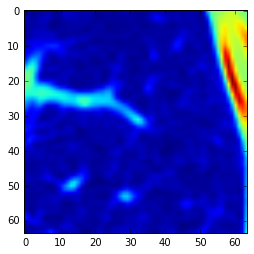

In [54]:
imshow(bads[0][2][100][32])

In [66]:
combined = list()
for bad in bads:
    combined += bad

In [45]:
candidate_type = 0
for i in combined:
    if 'vessel' in i[-1].lower():
        candidate_type += 1   

In [7]:
def extract_patches_vessels(lung, sobel, diff, amount=2):
    candidate = diff == VESSEL_LABEL
    if not candidate.sum():
        return [], [], []

    flag = 0
    start = 1

    labels, num = measure.label(candidate, background=0, return_num=True)

    marks = arange(start, num + 1)
    random.shuffle(marks)

    patches = list()
    sobels = list()
    masks = list()

    for k, label in enumerate(marks):

        overlaped = labels == label
        area = overlaped.sum()

        if area < LOWER or area > UPPER:
            continue
            
        coords = where(labels == label)

        medians = list()
        deltas = list()
        for j, coord in enumerate(coords):
            medians.append(median(coord))
            deltas.append((clip(int(medians[-1] - BORDER_VESSEL), 0, lung.shape[j]),
                           clip(int(medians[-1] + BORDER_VESSEL), 0, lung.shape[j])))
            
            delta = (deltas[-1][1] - deltas[-1][0]) // 2
            if delta < BORDER:
                top = lung.shape[j] - deltas[-1][1]
                bottom = deltas[-1][0]
                if top > BORDER - delta  and bottom > BORDER - delta:
                    deltas[-1] = (deltas[-1][0] - BORDER + delta,
                                  deltas[-1][1] + BORDER - delta)
                else:
                    bottom_top = [bottom, top]
                    min_shift = argmin(bottom_top)
                    max_shift = argmax(bottom_top)
                    remain = [0, 0]
                    remain[max_shift] = 2 * BORDER - (deltas[-1][1] - deltas[-1][0]) - 2 * bottom_top[min_shift]
                    deltas[-1] = (deltas[-1][0] - bottom_top[min_shift] - remain[0],
                                  deltas[-1][1] + bottom_top[min_shift] + remain[1])

        patches.append(lung[deltas[0][0]:deltas[0][1], deltas[1][0]:deltas[1][1], deltas[2][0]:deltas[2][1]])
        sobels.append(sobel[deltas[0][0]:deltas[0][1], deltas[1][0]:deltas[1][1], deltas[2][0]:deltas[2][1]])
        masks.append(diff[deltas[0][0]:deltas[0][1], deltas[1][0]:deltas[1][1], deltas[2][0]:deltas[2][1]])
        
        flag += 1
        if flag >= amount:
            return patches, sobels, masks
        
    return patches, sobels, masks


In [ ]:
for name in tqdm(preprocessed_files_pure):
    for side in ['left', 'right']:
        lung = load(join(PATH['LUNA_LUNGS'], name + 'lungs_' + side + '.npy'))
        sobel = load(join(PATH['LUNA_SOBEL'], name + 'sobel_' + side + '.npy'))
        diff = load(join(PATH['LUNA_MASKS'], name + 'diff_' + side + '.npy'))
        patch, sobel, mask = extract_patches_vessels(lung, sobel, diff, 10)
        for p in mask:
            if p.shape != (90, 90, 90):
                print(p.shape)
        add = random.randint(0, 9)
        for i in range(len(mask)):
            save(join(PATH['LUNA_CAE'], name + side + str(i + add) + '_patch'), patch[i])
            save(join(PATH['LUNA_CAE'], name + side + str(i + add) + '_sobel'), sobel[i])
            save(join(PATH['LUNA_CAE'], name + side + str(i + add) + '_mask'), mask[i])



  0%|          | 0/285 [00:00<?, ?it/s]